# Lab 07 - Data Preprocessing II

**DUE: Feb 16, 2024 (Friday)**  
Pair Programming: Optional  

Name(s): Samuel Baldwin  
Class: CSCI 349 - Intro to Data Mining  
Section: 01 
Semester: Spring 2024
Instructors: Brian King, Joshua Stough


# Objectives
* munge, Munge, MUNGE! (Or, wrangle it. Whatever works for you.)
* Data Integration
* Work on different techniques to assess similar variables

# Introduction
You already started the first part of this lab in Lab 6, in which you downloaded multiple years of hourly weather observations. If not, **be sure to complete the first part of the lab before you begin this lab.**

Work through this lab, and enter the answers to questions throughout this lab.

> Just a friendly reminder, please pay attention to the **[P]** vs. **[M]** vs. **[PM]** indicator. All [P] questions should be answered by writing the Python code that outputs the answer. Your code quality should be striving for smart, efficient, well-designed, well-documented code. For code that is asking for specific answers, you should be writing Python code that outputs the answer that is wanted, and nothing more.

In your last lab, you created a data directory, and downloaded a dataset from [The Pennsylvania State Climatologist](http://climate.met.psu.edu) representing hourly observations from 2000 – 2023 at Williamsport, PA (KIPT). The last lab focused quite a bit on preliminary steps to clean the data. You also had your first real exposure to dealing with times and dates with data, and understood first-hand why it's so important to be sure you set the proper type of every variable in your data. You should have printed out summary statistics for every variable, which should have included the occurrence of missing (e.g. NaN, null) values.

There are a few important observations to make here:

1. You had missing variables in data you downloaded
2. You had missing observations (i.e. the equipment did NOT record every hour!)
3. The data that you do have may be questionable, as it is quite noisy at times.

How will we create a complete dataset?

---
# Your task
The scenario for this lab is as follows. You have missing data, and you've been instructed to estimate the missing data from complete data retrieved from nearby stations under the premise that nearby stations are likely to have highly similar observations. This is a data integration challenge. KIPT is a pretty reliable station, but there are missing values, and a few other peculiarities.


In [96]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

---
**1)**	[P] Create a Python function called `process_FAA_hourly_data` that takes a filename (with path) as a string, and returns a completely processed pandas data frame of the data, ready for analysis. This is not as hard as it sounds, since you did all the work in the previous lab. Your function should:
a.	convert all numeric variables to their simplest numeric types
b.	convert the date/time stamp (first variable) to a pandas `DatetimeIndex`, which becomes the actual index for the data frame.
c.	drop the date time variable after moving it to become the index.
d.	If you did not do this in the last lab, make sure that the `DatetimeIndex` is localized to a specific timezone! This is very important! What time zone? Did you notice the header? The time stamp is in **GMT**, so be sure to localize the index accordingly by doing the following:

`df.index = df.index.tz_localize(tz='GMT')`

**NOTE: The last exercise in the previous lab had you 
eliminate a year from the data for the very last problem. Do NOT do that here! We'll explore that again later.**


In [138]:
# ANSWER

def process_FAA_hourly_csv(fname: str):
    """ This function takes a raw hourly weather data CSV file downloaded from 
        http://climate.psu.edu/data/ida and processes it.

        Parameters
            fname(str) - a string representing the path to a raw CSV file

        Returns
            A Pandas DataFrame object
    """
    df = pd.read_csv(fname, skiprows=15)
    for col in df.columns[2:]: 
        df[col] = pd.to_numeric(df[col], downcast ="float")
    df['Date/Time (GMT)'] = pd.to_datetime(df['Date/Time (GMT)'])
    df.set_index(df.columns[0], inplace = True)
    df.drop(df.columns[0], axis = 1)
    df.index = df.index.tz_localize(tz='GMT')
    return df


---
**2)**	[P] Use your new function to read in the KIPT data file you downloaded in the last lab. Store your data frame as `df_kipt`. Output the results of `info()` and `describe()` to confirm you read it in correctly.

In [139]:
# ANSWER
import os
loc = os.path.join(os.path.dirname(os.getcwd()), "data/faa_hourly-KIPT_20000101-20231231_raw.csv")
df_kipt = process_FAA_hourly_csv(loc)
print(df_kipt.describe())
df_kipt.info()


       Number of Observations (n/a)  Average Temp (F)   Max Temp (F)  \
count                 207730.000000     206660.000000  206660.000000   
mean                       1.666760         51.563175      51.698448   
std                        2.128558         18.778210      18.811342   
min                        0.000000        -11.900000     -11.900000   
25%                        1.000000         36.070000      37.000000   
50%                        1.000000         52.000000      52.000000   
75%                        1.000000         66.900002      66.900002   
max                       19.000000        102.000000     102.000000   

        Min Temp (F)  Average Dewpoint Temp (F)  1 Hour Precip (in)  \
count  206660.000000              206538.000000        33203.000000   
mean       51.432449                  40.370827            0.031460   
std        18.757771                  18.891506            0.079908   
min       -11.900000                 -20.900000            0.000000

---
**3)**	[P] In the last lab, you assessed the number of missing dates in your data, under the assumption that every hour should have an observation. For now, we'll ignore the fact that there are completely missing hourly observations from the weather station. Report the number of missing values in each variable of `df_kipt` from the data you have.

In [140]:
# ANSWER
df_kipt.isnull().sum()

Number of Observations (n/a)          0
Average Temp (F)                   1070
Max Temp (F)                       1070
Min Temp (F)                       1070
Average Dewpoint Temp (F)          1192
1 Hour Precip (in)               174527
Max Wind Gust (mph)              179502
Average Relative Humidity (%)      5580
Average Wind Speed (mph)            613
Average Station Pressure (mb)       361
Average Wind Direction (deg)      34047
Max Wind Speed (mph)                613
Unnamed: 13                      207730
dtype: int64

**4)**	[PM] Let's pay attention to `Average Temp (F)`. **Are there hours of the day are most likely to have missing values?** Report the frequency over each hour that has missing `Average Temp (F)` values. Be sure to report the LOCAL times according to the time zone `US/Eastern`. Output the hours in order of the most frequently missing to least. Then, as a comment, just interpret what you see. Do you see a pattern? Do missing temps tend to happen at a certain time of day?

(HINT: This might be challenging. First, as always, select the subset of your data matching your criteria. Then, for these data, look at the `index`. Date / time data types have LOTS of attributes themselves… such as `hour`. What do you get if you count these values?)

In [141]:
# ANSWER
by_hour = df_kipt.groupby(df_kipt.index.hour)["Average Temp (F)"].apply(lambda x: x.isnull().sum())
by_hour.index = pd.to_datetime(by_hour.index, format = '%H').tz_localize("UTC").tz_convert("EST").hour
by_hour

Date/Time (GMT)
19    34
20    33
21    37
22    35
23    37
0     37
1     37
2     39
3     40
4     40
5     43
6     45
7     43
8     44
9     64
10    76
11    67
12    67
13    49
14    44
15    40
16    40
17    40
18    39
Name: Average Temp (F), dtype: int64

**ANSWER:** It appears that most commonly there are missing data points between 9-12 pm.

---
**5)**	[PM] Repeat the previous exercise, but this time, assess the same variable for the day of the week. (NOTE: Be sure to note what a 0 is. In pandas, a 0 for day of the week is a Monday! See [this link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.dayofweek.html) for more info).

In [142]:
# ANSWER
by_day = df_kipt.groupby(df_kipt.index.day_name())["Average Temp (F)"].apply(lambda x: x.isnull().sum())
by_day

Date/Time (GMT)
Friday       153
Monday       159
Saturday      37
Sunday       107
Thursday     185
Tuesday      218
Wednesday    211
Name: Average Temp (F), dtype: int64

**ANSWER:**

It appears that the most common day for null values is Tuesday, followed by Thursday. 


---
**6)**	[P] Read in the file `FAA_PA_stations.csv` provided on Moodle. It's not actually a comma separated file, but a *tab* separated file.  Store the data frame as stations. Show `stations.info()` after you read in the data.

In [143]:
# ANSWER
stations = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data/FAA_PA_stations.csv"), sep = "\t")
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                46 non-null     object 
 1   Name              46 non-null     object 
 2   County            45 non-null     object 
 3   State             46 non-null     object 
 4   Lat               46 non-null     float64
 5   Lon               46 non-null     float64
 6   Elevation (feet)  46 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.6+ KB


---
**7)**	[P] As usual, you must always assess the quality and completeness of your data. Are there any observations (rows) in `stations` that have missing data? Output them, then eliminate them from your data. Be sure to `reset_index(drop=True)` to reset the index in case any observations are dropped. Output `stations.info()` again.

In [144]:
# ANSWER:
print(stations[stations.isnull().any(axis=1)])
stations = stations.dropna()
stations.info()

      ID            Name County State     Lat     Lon  Elevation (feet)
24  KUKT  QUAKERTOWN ARP    NaN    PA  40.435 -75.381             524.9
<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 0 to 45
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                45 non-null     object 
 1   Name              45 non-null     object 
 2   County            45 non-null     object 
 3   State             45 non-null     object 
 4   Lat               45 non-null     float64
 5   Lon               45 non-null     float64
 6   Elevation (feet)  45 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


---
**8)**	[P] Examine the data frame of `stations` by showing the first few observations using `stations.head(10)`. In particular, pay close attention to the variables `Lat` and `Lon`. These represent the precise latitude and longitude geolocation for the weather station.

In [145]:
# ANSWER
stations.head(10)

,ID,Name,County,State,Lat,Lon,Elevation (feet)
0,KABE,ALLENTOWN,LEHIGH,PA,40.65,-75.44,376.0
1,KAOO,ALTOONA,BLAIR,PA,40.29,-78.32,1504.0
2,KBVI,BEAVER FALLS,BEAVER,PA,40.77,-80.39,1230.0
3,KBFD,BRADFORD,MCKEAN,PA,41.80,-78.64,2142.0
4,KBTP,BUTLER,BUTLER,PA,40.77,-79.95,1250.0
5,KCXY,CAPITAL CITY,YORK,PA,40.22,-76.85,340.0
6,KFIG,CLEARFIELD,CLEARFIELD,PA,41.04,-78.41,1516.0
7,KDYL,DOYLESTOWN,BUCKS,PA,40.33,-75.12,394.0
8,KDUJ,DUBOIS,JEFFERSON,PA,41.18,-78.90,1814.0
9,KERI,ERIE,ERIE,PA,42.08,-80.17,730.0


---
**9)**	Create a new variable in `stations` called `distKIPT` that stores the distance of every station in PA to Williamsport (KIPT). Use a standard Euclidean distance calculation (over latitude and longitude) to compute the distance between the stations.

In [146]:
# ANSWER
kipt_coords = stations.loc[stations["ID"] == "KIPT", ['Lat', 'Lon']].values[0]
def calc_dist(row): 
    return np.linalg.norm(kipt_coords - np.array([row["Lat"], row["Lon"]]))
stations["distKIPT"] = stations.apply(calc_dist, axis = 1)

---
**10)**	[P] Output the top 10 stations that are closest to KIPT. (The closest one should be to itself!) The stations should be listed in order of increasing distance from KIPT.

In [147]:
# ANSWER:
stations.nsmallest(10, "distKIPT")

,ID,Name,County,State,Lat,Lon,Elevation (feet),distKIPT
30,KIPT,WILLIAMSPORT,LYCOMING,PA,41.24,-76.92,520.0,0.000000
27,KSEG,SELINSGROVE,SNYDER,PA,40.82,-76.86,444.0,0.424264
18,KMUI,MUIR ARMY AIR FIELD,LEBANON,PA,40.43,-76.57,489.0,0.882383
28,KUNV,UNIVERSITY PARK,CENTRE,PA,40.85,-77.85,1240.0,1.008464
5,KCXY,CAPITAL CITY,YORK,PA,40.22,-76.85,340.0,1.022399
16,KMDT,MIDDLETOWN,DAUPHIN,PA,40.19,-76.76,312.0,1.062121
26,KAVP,SCRANTON,LUZERNE,PA,41.33,-75.72,956.0,1.203370
13,KLNS,LANCASTER,LANCASTER,PA,40.12,-76.29,403.0,1.285029
25,KRDG,READING,BERKS,PA,40.37,-75.96,360.0,1.295569
32,KTHV,YORK,YORK,PA,39.92,-76.87,486.0,1.320947


---
**11)**	[P] Using your results, go back to the [PSU climate website](http://climate.met.psu.edu/data/ida/) and download the *faa_hourly* data for the THREE closest stations that have hourly data available in the same date range as the data you downloaded from KIPT (i.e. 2000-01-01 -> 2023-12-31). (HINT: You may need to skip KMUI because it does not have data available in this range.) Copy the data into your `data` folder. Then, read in each data file into its own data frame using your function. You should have four data frames: `df_kipt`, and three other data frames representing the three closest stations. Show the result of info() on your three new data frames.

In [148]:
# ANSWER:
df_kseg = process_FAA_hourly_csv(os.path.join(os.path.dirname(os.getcwd()), "data/faa_hourly-KSEG_20000101-20231231.csv"))
df_kunv = process_FAA_hourly_csv(os.path.join(os.path.dirname(os.getcwd()), "data/faa_hourly-KUNV_20000101-20231231.csv"))
df_kcxy = process_FAA_hourly_csv(os.path.join(os.path.dirname(os.getcwd()), "data/faa_hourly-KCXY_20000101-20231231.csv"))
print(df_kseg.info())
print(df_kunv.info())
print(df_kcxy.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 206197 entries, 2000-01-01 00:00:00+00:00 to 2023-12-31 23:00:00+00:00
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Number of Observations (n/a)   206197 non-null  int64  
 1   Average Temp (F)               205508 non-null  float32
 2   Max Temp (F)                   205508 non-null  float32
 3   Min Temp (F)                   205508 non-null  float32
 4   Average Dewpoint Temp (F)      205181 non-null  float32
 5   1 Hour Precip (in)             30385 non-null   float32
 6   Max Wind Gust (mph)            21640 non-null   float32
 7   Average Relative Humidity (%)  200601 non-null  float32
 8   Average Wind Speed (mph)       205109 non-null  float32
 9   Average Station Pressure (mb)  205949 non-null  float32
 10  Average Wind Direction (deg)   154574 non-null  float32
 11  Max Wind Speed (mph)           205109 non-nul

---
You're going to repair the KIPT data, but how? Since we have data from nearby stations with independent readings, let's see how many of our missing data can be filled in from a nearby station. Again, for simplicity, we're only going to focus on average temperature (column 1).

As an advanced CS elective, you should be going for efficient, clean code. It need not be perfect, but it should be well-thought out and documented so you can readily show it to prospective employers, and also use it later! Remember - you are going to start doing more advanced analyses very soon! So, when your code or your output is not obvious or intuitive, write markdown after your output is generated that explains your code, and interprets your results!


---
**12)**	[P] Create a new data frame called `df_ave_temps` that contains the average temperature from all four stations. Name the variables with the four-letter station identifier (e.g. "KIPT"). The index should have a COMPLETE hourly date range from the start date `20000101 00:00:00 GMT` to finish date `20231231 23:00:00 GMT`. The results should be a complete dataset with an observation for every hour. If hourly observations are missing from the station you are copying from, then a NaN value should be stored for that entry. You will use these data for the remainder of this exercise.

Show `df_ave_temps.info()`

(NOTE – Depending on how you do this, it might take a bit of processing time. Be patient.)



In [149]:
# ANSWER
full_index = pd.date_range(start = "2000-01-01", end = "2023-12-31", freq = "H", tz = "GMT")
kipt_adj = df_kipt[["Average Temp (F)"]].reindex(index = full_index, fill_value = np.nan)
kseg_adj = df_kseg[["Average Temp (F)"]].reindex(index = full_index, fill_value = np.nan)
kunv_adj = df_kunv[["Average Temp (F)"]].reindex(index = full_index, fill_value = np.nan)
kcxy_adj = df_kcxy[["Average Temp (F)"]].reindex(index = full_index, fill_value = np.nan)
df_ave_temps = pd.concat([kipt_adj, kseg_adj, kunv_adj, kcxy_adj], axis = 1)
df_ave_temps.columns = ["KIPT", "KSEG", "KUNV", "KCXY"]
df_ave_temps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210361 entries, 2000-01-01 00:00:00+00:00 to 2023-12-31 00:00:00+00:00
Freq: H
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   KIPT    206637 non-null  float32
 1   KSEG    205485 non-null  float32
 2   KUNV    201132 non-null  float32
 3   KCXY    161342 non-null  float32
dtypes: float32(4)
memory usage: 4.8 MB


---
**13)**	[P] Each station has missing observations for average temperature. Report the number of missing average temperature readings in `df_ave_temps` for each location.

HINT: Your answer should be something like:
```
KIPT     3724
KSEG     4876
KUNV     9229
KCXY    49019
```

In [150]:
# ANSWER:

df_ave_temps.isnull().sum()

KIPT     3724
KSEG     4876
KUNV     9229
KCXY    49019
dtype: int64

---
**14)**	[P] Now, let's get to why we are considering these alternative stations. Report the number of missing values in the average temp for KIPT that have at least one alternative station that is NOT missing for the same hour. You should output a statement like, `There are XXXX out of XXXX missing KIPT temps that can be restored from other locations.`

Also, show the first 10 observations of these data that meet these criteria using head(10). (The first few observations should look something like...

```
                           KIPT       KSEG       KUNV       KCXY
2000-01-03 18:00:00+00:00   NaN  53.099998  57.200001        NaN
2000-01-05 17:00:00+00:00   NaN  35.099998  32.000000        NaN
2000-01-06 20:00:00+00:00   NaN  41.000000  39.200001        NaN
2000-01-07 14:00:00+00:00   NaN  36.000000  35.599998  35.599998
```


In [151]:
# ANSWER
#df_ave_temps.
kipt_restorable = df_ave_temps.loc[(df_ave_temps['KIPT'].isnull()) & ((df_ave_temps['KSEG'].notnull()) | (df_ave_temps['KUNV'].notnull()) |((df_ave_temps["KCXY"].notnull())))]
print(f'There are {len(kipt_restorable)} out of {df_ave_temps["KIPT"].isnull().sum()} missing KIPT temps that can be restored from other locations.')
kipt_restorable.head(10)

There are 2257 out of 3724 missing KIPT temps that can be restored from other locations.


,KIPT,KSEG,KUNV,KCXY
2000-01-03 18:00:00+00:00,NaN,53.099998,57.200001,NaN
2000-01-05 17:00:00+00:00,NaN,35.099998,32.000000,NaN
2000-01-06 20:00:00+00:00,NaN,41.000000,39.200001,NaN
2000-01-07 14:00:00+00:00,NaN,36.000000,35.599998,35.599998
2000-01-10 02:00:00+00:00,NaN,39.000000,37.400002,NaN
2000-01-10 03:00:00+00:00,NaN,39.000000,35.599998,NaN
2000-01-10 04:00:00+00:00,NaN,36.000000,NaN,NaN
2000-01-10 05:00:00+00:00,NaN,32.000000,NaN,NaN
2000-01-10 06:00:00+00:00,NaN,34.000000,NaN,NaN
2000-01-10 07:00:00+00:00,NaN,35.349998,NaN,NaN


---
**15a)**	[P] Remember that exercise in the previous lab that gathered the number of missing data by year? Report the number of missing data in KIPT by year that CANNOT be restored from any of the other stations.



In [152]:
# ANSWER
kipt_unrestorable = df_ave_temps.loc[(df_ave_temps['KIPT'].isnull()) & ((df_ave_temps['KSEG'].isnull())  & (df_ave_temps['KUNV'].isnull())& ((df_ave_temps["KCXY"].isnull())))]
unrestorable = kipt_unrestorable.groupby(kipt_unrestorable.index.year).size()
unrestorable.name = "Missing"
unrestorable

2000    739
2001     13
2002      4
2003     15
2004      7
2005      7
2006      6
2007     34
2008    109
2009     24
2010     10
2011     13
2012     41
2013     28
2014     11
2015     27
2016      8
2017     61
2018     44
2019     19
2020     22
2021     89
2022     82
2023     54
Name: Missing, dtype: int64

---
**15b)** Display a barchart showing your results. Annotate the chart with the year that is standing out as the least likely to be successfully restored.

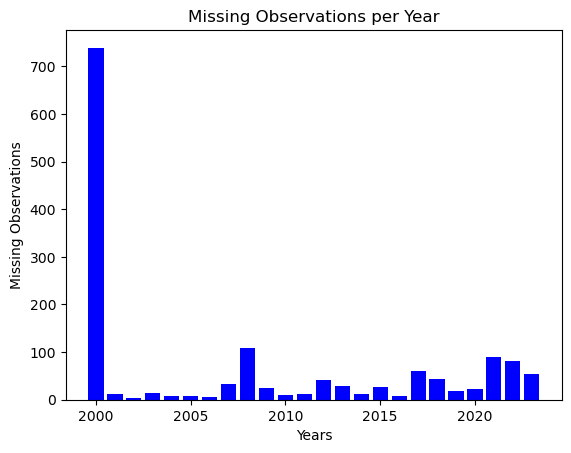

In [153]:
# ANSWER
plt.bar(unrestorable.index, unrestorable, color='blue')

plt.xlabel("Years")
plt.ylabel("Missing Observations")
plt.title("Missing Observations per Year")
plt.show()


---
### A note about wide vs. long format data frames

When plotting multiple variables, such as you want to do here (i.e., KIPT, KSEG, KUNV and KCXY are all variables), Seaborn is not quite as friendly. However, Seaborn works very well when your data with many variables (referred to as a "wide" format") is converted to a "long" format. A long format interpretation of an existing dataframe introduces identifier variables that contain the name of the column selected, and value variables that contain the values of other columns of interest. Fortunately, pandas makes this easy using the `melt()` function.

Let's suppose that dataframe `df` represents the subset of data I want to plot. For example, let's work with `df_ave_temps` that you created above. Then, I can do the following:

```
df=df_ave_temps.melt(value_vars=["KIPT","KSEG","KUNV","KCXY"],
           var_name="location",
           value_name="Ave Temp (F)",
           ignore_index=False)
```
What do I get in return?

```
                          location  Ave Temp (F)
2000-01-01 00:00:00+00:00     KIPT          26.1
2000-01-01 01:00:00+00:00     KIPT          26.1
2000-01-01 02:00:00+00:00     KIPT          26.1
2000-01-01 03:00:00+00:00     KIPT          26.1
2000-01-01 04:00:00+00:00     KIPT          26.1
...                            ...           ...
```

Notice instead of different columns for each station, I now have a new variable, `location`, that contains the location specified from the `value_vars` parameter. This is a long format dataset.

Now, you can easily plot these data using Seaborn! For example, you could try this one out on `df`:

```
g = sns.FacetGrid(data=df,row="location",hue="location")
g.map(sns.scatterplot,"date","Ave Temp (F)",s=3)
plt.show()
```


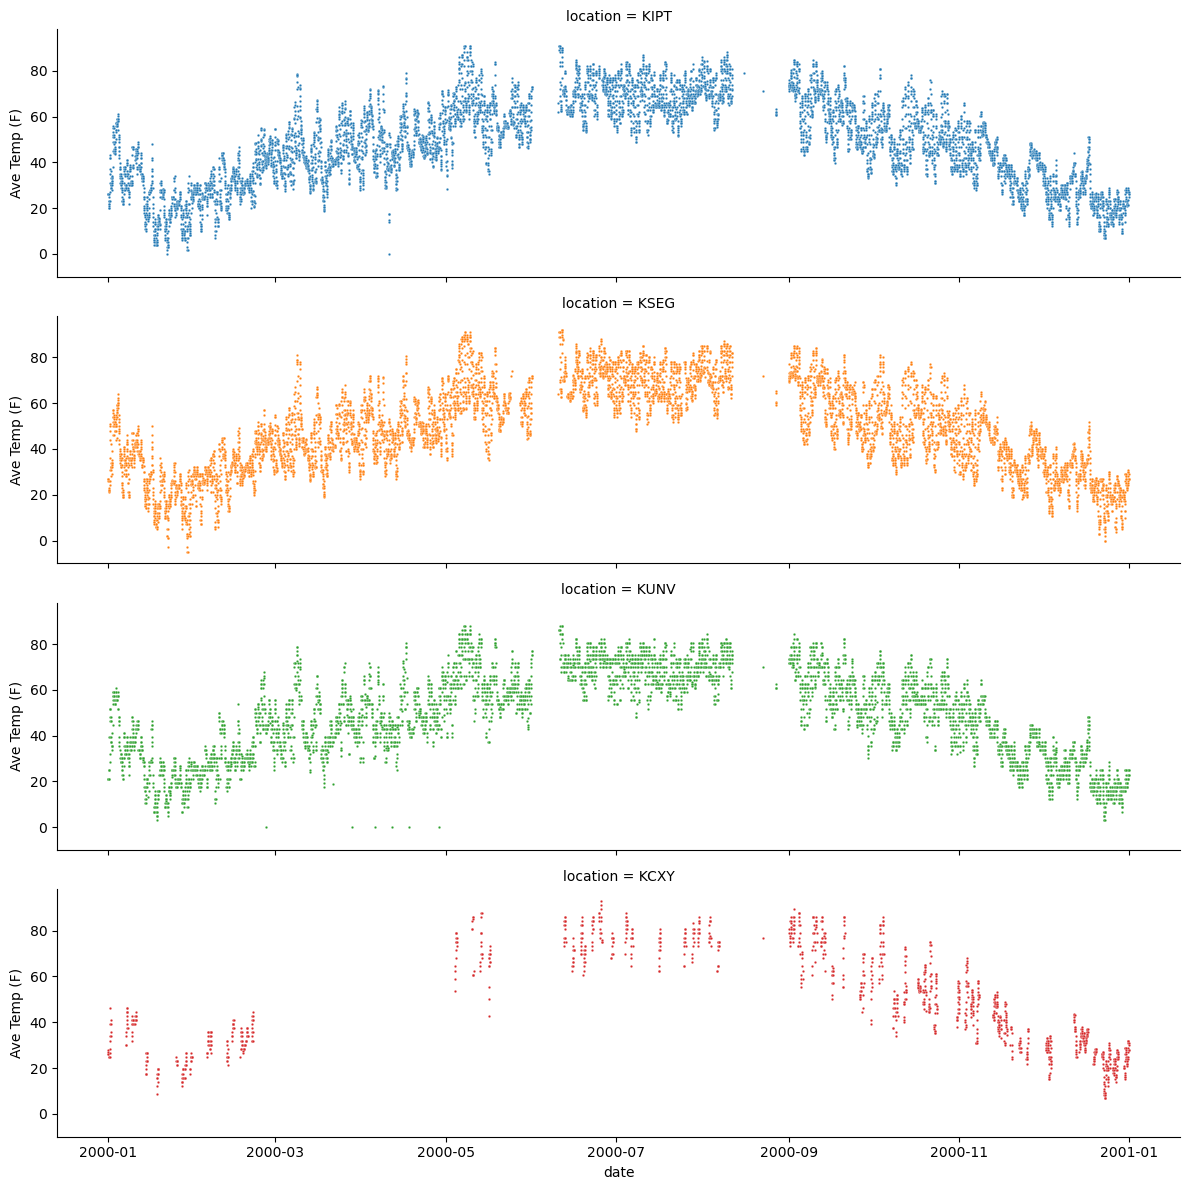

In [156]:
# ANSWER
df=df_ave_temps.melt(value_vars=["KIPT","KSEG","KUNV","KCXY"],
           var_name="location",
           value_name="Ave Temp (F)",
           ignore_index=False)
df = df.iloc[df.index.year == 2000].reset_index(names=['date'])

g = sns.FacetGrid(data=df,row="location",hue="location", aspect = 4)
g.map(sns.scatterplot,"date","Ave Temp (F)",s=3)
plt.show()

**ANSWER:**
It looks like KCXY has the most missing values, and almost all stations have missing data in the 6th and 8th months of the year.

---
**17)**	[P] Looking at your plot of 2000 over all stations should reveal that KUNV is problematic at 6 different times. Report these observations, but report them from your full KUNV dataframe. Show only those observations.

In [157]:
# ANSWER
df_kunv.loc[df_kunv["Average Temp (F)"] == 0]

,Number of Observations (n/a),Average Temp (F),Max Temp (F),Min Temp (F),Average Dewpoint Temp (F),1 Hour Precip (in),Max Wind Gust (mph),Average Relative Humidity (%),Average Wind Speed (mph),Average Station Pressure (mb),Average Wind Direction (deg),Max Wind Speed (mph),Unnamed: 13
Date/Time (GMT),,,,,,,,,,,,,
2000-02-26 13:00:00+00:00,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,8.100000,0.000000,NaN,8.100000,NaN
2000-03-28 14:00:00+00:00,1,0.0,0.0,0.0,26.600000,0.0,20.799999,0.0,13.900000,990.900024,NaN,13.900000,NaN
2000-04-05 14:00:00+00:00,1,0.0,0.0,0.0,0.000000,0.0,26.299999,0.0,20.799999,0.000000,NaN,20.799999,NaN
2000-04-11 22:00:00+00:00,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,5.800000,0.000000,NaN,5.800000,NaN
2000-04-17 21:00:00+00:00,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,8.100000,0.000000,NaN,8.100000,NaN
2000-04-28 15:00:00+00:00,1,0.0,0.0,0.0,35.599998,0.0,0.000000,0.0,9.200000,1013.900024,NaN,9.200000,NaN


---
**18)**	[M] How could you algorithmically detect those problems? Keep in mind that simply saying to turn 0.0 into NaN is not an acceptable solution. 0.0 may very well be a real value! Is there a better approach? (Yes, yes there is.)

**ANSWER:** The mechanism for detecting these problems would probably be examining the nearby weather stations and seeing if the difference between any given data point is a certain threshold away from the others, which would indicate that it is a fautly value. Additionally looking for dramatic hour swings past a certain threshold could be helpful for detecting issues.




---
**19)**	[P] Now, write the code to generate line plot(s) for all of KIPT visually, and only KIPT. Look for peculiarities, usually indicated by a sudden change that is outside of what would be considered normal, or an extreme temperature reading that would be impossible to observe in reality.

<Axes: xlabel='Number of Observations (n/a)', ylabel='vals'>

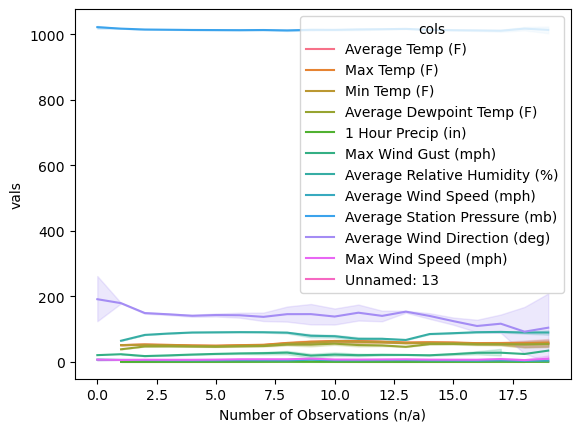

In [158]:
# ANSWER
kipt_melted = df_kipt.melt("Number of Observations (n/a)", var_name = "cols", value_name = "vals")
sns.lineplot(kipt_melted, x = "Number of Observations (n/a)", y = "vals", hue = "cols")


---
**20)**	[P] Compute a new Series that represents a running delta temperature between adjacent average temperature readings for KIPT. Then, plot the distribution of these data using whatever visualization you think characterizes this distribution best. (HINT: It's a series of observations over a single numeric variable. What type of plot can reveal the distribution of these data?)

Text(0.5, 1.0, 'Adjacent Point Deltas in Average Temp (F)')

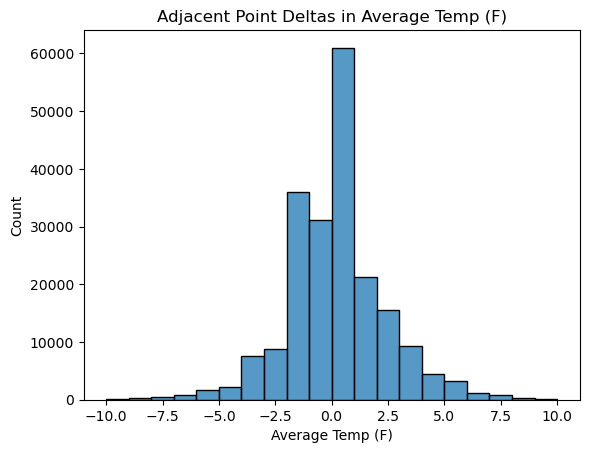

In [160]:
# ANSWER
delta_adj_kipt = df_kipt["Average Temp (F)"].diff()
sns.histplot(delta_adj_kipt, binrange = [-10,10], binwidth = 1)
plt.title("Adjacent Point Deltas in Average Temp (F)")


---
**21)**	[P] When you see peculiarities, it's important to take a dive and look at some of the extreme cases. Use your delta data and show 20 dates listed in order of the largest absolute delta. You should be able to confirm that the largest delta readings are in 2000. Your result should looks something like this...

```
                               delta  abs_delta
2000-04-10 16:00:00+00:00  47.900002  47.900002
2000-04-10 20:00:00+00:00  35.700001  35.700001
2000-04-10 17:00:00+00:00 -30.630001  30.630001
2000-05-01 15:00:00+00:00  30.130001  30.130001
```

In [161]:
# ANSWER
delta_adj_kipt.name = "delta"
df_delta = pd.DataFrame(delta_adj_kipt)
df_delta["abs_delta"] = np.abs(delta_adj_kipt)
df_delta.sort_values(by = "abs_delta", ascending = False).head(20)

,delta,abs_delta
Date/Time (GMT),,
2000-04-10 16:00:00+00:00,47.900002,47.900002
2000-04-10 20:00:00+00:00,35.700001,35.700001
2000-04-10 17:00:00+00:00,-30.630001,30.630001
2000-05-01 15:00:00+00:00,30.130001,30.130001
2000-06-10 17:00:00+00:00,27.000000,27.000000
2000-04-10 13:00:00+00:00,-25.900002,25.900002
2000-06-24 20:00:00+00:00,22.000000,22.000000
2000-05-01 14:00:00+00:00,-21.799999,21.799999
2009-08-10 16:00:00+00:00,21.099998,21.099998


---
We already discovered some substantial problems with 2000. So, see if you can pick out a couple of other dates, and see if the delta values seem plausible. You may want to generate a plot near the value of interest to help you understand the delta, and consider if it's an error or a real value.

For example, consider the largest value from my example output above, July 7, 2012. Is that real??? Searching for historical weather data for Williamsport for July 7, 2012 led me to [this site on weatherspark](https://weatherspark.com/h/d/21192/2012/7/7/Historical-Weather-on-Saturday-July-7-2012-in-Williamsport-Pennsylvania-United-States#Figures-Temperature) You can see from that page that thunderstorms were rolling through the area in the afternoon and evening hours, and indeed the temperature really did drop. Kinda cool (ehh, no pun intended), but more importantly, it should also give you a warning to always be careful with the conclusions that you draw about your data. Sometimes, extreme values and outliers are indeed correct!

---
**22)** [P] Let's see which of our nearby stations have the most similar values. Write a function called `compare_station` that takes two `Series` objects of numeric data, and computes the sum of the absolute value of the difference between each pair of numbers in both `Series`. You should only sum the values that have valid values for both entries. Return the average of these absolute differences.

Then, call `compare_station` on KIPT and each of the other stations, but pass only the average temp vector from each station using your `df_ave_temps` DataFrame.



In [162]:
# ANSWER
def compare_station(series1: pd.Series, series2: pd.Series):
    ''' Compare two numeric Series objects. It is assumed that they are already aligned. Return 
        the mean of the absolute value of the difference between each value
    '''
    return series1.sub(series2).apply(lambda x : abs(x)).mean()

print(f'Average diff between KIPT and KSEG: {round(compare_station(df_kipt["Average Temp (F)"], df_kseg["Average Temp (F)"]),2)}')
print(f'Average diff between KIPT and KUNV: {round(compare_station(df_kipt["Average Temp (F)"], df_kunv["Average Temp (F)"]),2)}')
print(f'Average diff between KIPT and KCXY: {round(compare_station(df_kipt["Average Temp (F)"], df_kcxy["Average Temp (F)"]),2)}')


Average diff between KIPT and KSEG: 2.05
Average diff between KIPT and KUNV: 2.99
Average diff between KIPT and KCXY: 3.93


---
**23)**	[P] As we learned in class, you could compute a correlation coefficient between columns of data to determine similarity. Compute the correlation coefficient between the average temp of KIPT, and each of the other stations you downloaded. They should all be very close to 1, but not quite. Be sure you show at least 5-6 digits for precision (look up `pd.set_option`). What does this technique suggest which station is most similar?

In [163]:
# ANSWER
pd.set_option('display.precision', 6)

print(f'Correlation Coefficient KIPT-KSEG: {round(df_kipt["Average Temp (F)"].corr(df_kseg["Average Temp (F)"]),6)}')
print(f'Correlation Coefficient KIPT-KUNV: {round(df_kipt["Average Temp (F)"].corr(df_kunv["Average Temp (F)"]),6)}')
print(f'Correlation Coefficient KIPT-KCXY: {round(df_kipt["Average Temp (F)"].corr(df_kcxy["Average Temp (F)"]),6)}')

Correlation Coefficient KIPT-KSEG: 0.988312
Correlation Coefficient KIPT-KUNV: 0.979976
Correlation Coefficient KIPT-KCXY: 0.980485


---
**24)**	[M] Interpret what you have observed so far. Which station is most similar? How would this affect your approach to cleaning your data? Are there other things you might do to clean your data?

**ANSWER:** It appears that the station that is most similar to KIPT is KSEG. This would indicate that when filling the data in KIPT with data from other data sets, KSEG would be the first choice to fill it, then KCXY and then KUNV. We could also average the other locations with a weight to more heavily weight KSEG. 


---
**25)**	 [P] Create a new attribute called `KIPT_GOOD` in your `df_ave_temps` data frame that keeps all of the original average temp data, but takes the readings from the closest station to replace in the NA values. Be sure to replace the data from the best representative first, then the second best. Ignore the third. When you perform data cleaning, NEVER DELETE YOUR ORIGINAL DATA! Either store it, or just create a separate attribute of cleaned data, or create a separate data frame. AND, be sure to print out what you are doing. Be sure to include a before and after view to indicate how many values you fixed.

For example, my code output the following:
```
Starting with 3724 missing values in KIPT
Copying 1833 values from KSEG
Next, copying 391 values from KUNV
We still have 1500 missing values in KIPT
```


In [164]:
# ANSWER
df_ave_temps["KIPT_GOOD"] = df_ave_temps["KIPT"]
print(f'Starting with {df_ave_temps["KIPT_GOOD"].isnull().sum()} missing values in KIPT.')
original_nulls = df_ave_temps["KIPT_GOOD"].isnull().sum()
df_ave_temps["KIPT_GOOD"] = df_ave_temps["KIPT_GOOD"].fillna(df_ave_temps["KSEG"])
print(f'Copying {original_nulls-df_ave_temps["KIPT_GOOD"].isnull().sum()} values from KSEG')
original_nulls = df_ave_temps["KIPT_GOOD"].isnull().sum()
df_ave_temps["KIPT_GOOD"] = df_ave_temps["KIPT_GOOD"].fillna(df_ave_temps["KSEG"])
df_ave_temps["KIPT_GOOD"] = df_ave_temps["KIPT_GOOD"].fillna(df_ave_temps["KUNV"])
print(f'Next, copying {original_nulls-df_ave_temps["KIPT_GOOD"].isnull().sum()} values from KSEG')
print(f'We still have {df_ave_temps["KIPT_GOOD"].isnull().sum()} missing values in KIPT.')

Starting with 3724 missing values in KIPT.
Copying 1833 values from KSEG
Next, copying 391 values from KSEG
We still have 1500 missing values in KIPT.


---
**26)**	[P] We want to consider setting singleton missing observations, i.e. those missing values that are surrounded by two good observations, as candidates to fill in with the average of their surrounding values. Before we do that, report the number of missing values left in `KIPT_GOOD` that are singleton missing values.



In [165]:
# ANSWER
singleton = (df_ave_temps['KIPT_GOOD'].isnull() & df_ave_temps['KIPT_GOOD'].shift(1).notnull() & df_ave_temps['KIPT_GOOD'].shift(-1).notnull())
singleton.sum()

193

---
**27)**	[P] Now, convert all singletons missing values in `KIPT_GOOD` to an average of the surrounding observations. For example […, 2, NaN, 5, …] would be filled in with $(2+5)/2 = 3.5$ for the NaN value. Then, report the number of values that are still missing in `KIPT_GOOD`.



In [166]:
# ANSWER

df_ave_temps.loc[singleton, 'KIPT_GOOD'] = (df_ave_temps['KIPT_GOOD'].shift(1) + df_ave_temps['KIPT_GOOD'].shift(-1)) / 2
df_ave_temps["KIPT_GOOD"].isnull().sum()

1307

---
**28)**	[P] Eliminate that first year of data from `df_ave_temps`. There are too many missing values in these data to make it worthwhile.

In [167]:
# ANSWER
df_ave_temps = df_ave_temps.loc[df_ave_temps.index.year != 2000]

---
**29)**	[P] Generate a final report of the total number of missing values in df_ave_temps.KIPT_GOOD by year by plotting the barchart showing the number of missing values by year.

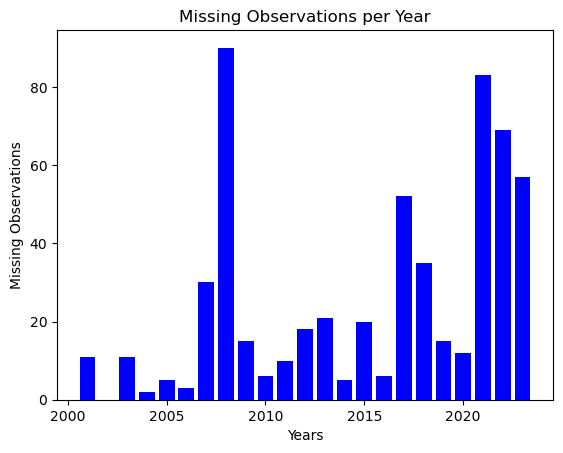

In [168]:
# ANSWER
df_final_missing = df_ave_temps.loc[df_ave_temps['KIPT_GOOD'].isnull()]
df_final_missing = df_final_missing.groupby(df_final_missing.index.year)
data = df_final_missing.size()


plt.bar(data.index, data, color='blue')

plt.xlabel("Years")
plt.ylabel("Missing Observations")
plt.title("Missing Observations per Year")
plt.show()

#df_final_missing.plot(type = "bar")

---
**30)**	[P] Finally, create three good, clean lineplots of `KIPT_GOOD`. More specifically, create three plots using different averaging times. One should be the raw data. Then, create one that shows the average temperature by month. Then, create one with average temperature by year.

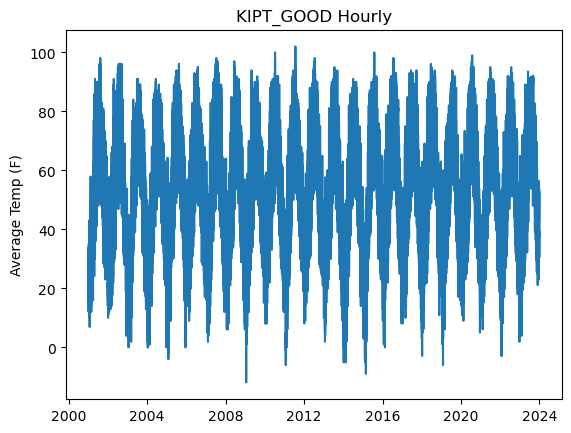

In [169]:
# ANSWER

sns.lineplot(df_ave_temps, x = df_ave_temps.index, y = df_ave_temps["KIPT_GOOD"])
plt.ylabel("Average Temp (F)")
plt.title("KIPT_GOOD Hourly")
plt.show()

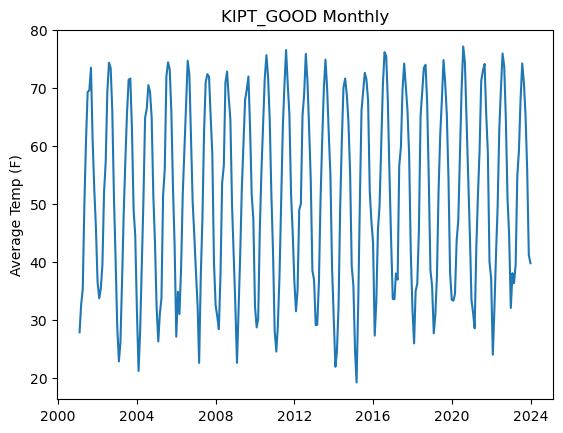

In [170]:
month_adj = df_ave_temps["KIPT_GOOD"].resample('M').mean()
sns.lineplot(month_adj , x = month_adj .index, y = month_adj )
plt.ylabel("Average Temp (F)")
plt.title("KIPT_GOOD Monthly")

plt.show()

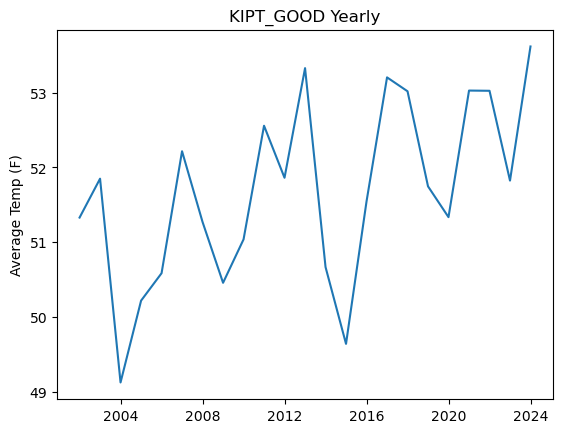

In [171]:
year_adj = df_ave_temps["KIPT_GOOD"].resample('Y').mean()
sns.lineplot(year_adj , x = year_adj .index, y = year_adj )
plt.ylabel("Average Temp (F)")
plt.title("KIPT_GOOD Yearly")
plt.show()